## 프로젝트: 다양한 OCR모델 비교하기

## 검증용 데이터셋 준비

이미지가 많을수록 좋겠지만 검증해야 할 항목별로 고루 갖춰지는 것도 중요합니다. 20장정도

In [1]:
work_dir = './test_images/'
img_file_paths = []
for i in range(1,6):
    img_file_paths.append(work_dir+'test_image_{}.jpg'.format(i))

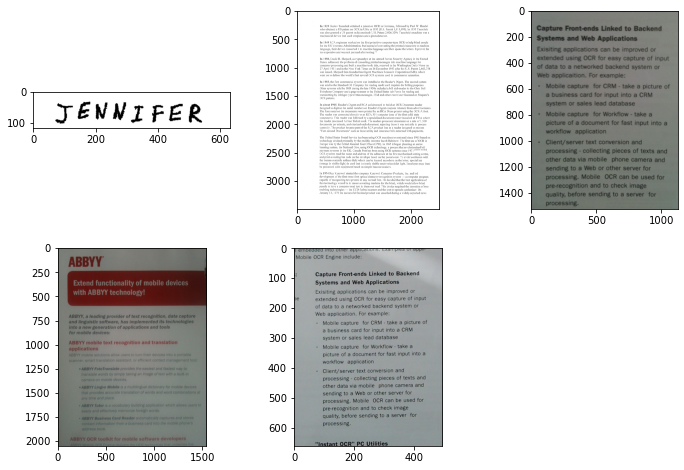

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from os import listdir
from PIL import Image as PImage

def loadImages(path):
    
    imagesList = listdir(path)
    loadedImages = []
    for image in imagesList:
        img = PImage.open(path + image)
        loadedImages.append(img)

    return loadedImages

imgs = loadImages(work_dir)
plt.figure(figsize=(12, 8))
for idx,img in enumerate(imgs):
    plt.subplot(2,3,idx+1)   
    plt.imshow(img)

## Google OCR API, keras-ocr, Tesseract로 테스트 진행

### Google OCR API

In [3]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [5]:
for path in img_file_paths:
    detect_text(path)

Texts:

"JENNIFER
"

"JENNIFER"
bounds: (73,30),(543,34),(542,104),(72,100)
Texts:

"Capture Front-ends Linked to Backend
Systems and Web Applications
Exisiting applications can be improved or
extended using OCR for easy capture of input
of data to a networked backend system or
Web applicaition. For example:
Mobile capture for CRM - take a picture of
a business card for input into a CRM
system or sales lead database
Mobile capture for Workflow - take a
picture of a document for fast input into a
workflow application
Client/server text conversion and
processing - collecting pieces of texts and
other data via mobile phone camera and
sending to a Web or other server for
processing. Mobile OCR can be used for
pre-recognition and to check image
quality, before sending to a server for
processing.
"

"Capture"

"Front-ends"

"Linked"

"to"

"Backend"

"Systems"

"and"

"Web"

"Applications"

"Exisiting"

"applications"

"can"

"be"

"improved"

"or"

"extended"

"using"

"OCR"

"for"

"easy"


### keras-ocr

In [39]:
img_file_paths

[&#39;./test_images/test_image_1.jpg&#39;,
 &#39;./test_images/test_image_2.jpg&#39;,
 &#39;./test_images/test_image_3.jpg&#39;,
 &#39;./test_images/test_image_4.jpg&#39;,
 &#39;./test_images/test_image_5.jpg&#39;]

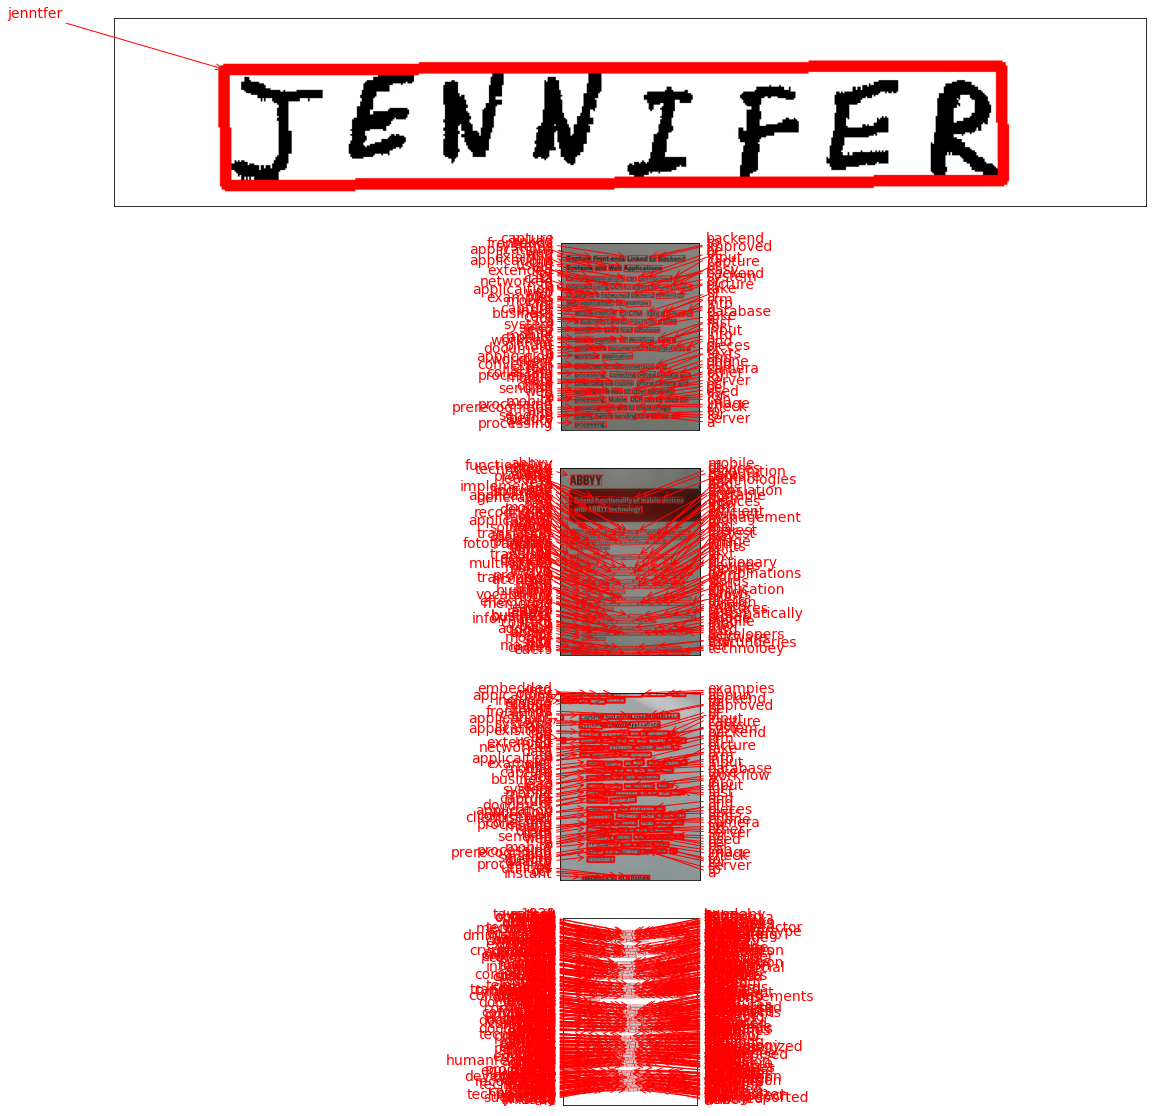

In [42]:
# import keras_ocr
images = [ keras_ocr.tools.read(img) for img in img_file_paths]
prediction_groups = [pipeline.recognize([img]) for img in img_file_paths]


# 인식 결과 시각화
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### Tesseract

In [10]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)
    image_name = image_path.split('/')[-1].split('.')[0]

# pytesseract 의 Output 을 사용해서 결과값의 형식을 딕셔너리(DICT) 형식으로 설정해주게 됩니다.
    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{image_name}_{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [11]:
img_file_paths

['./test_images/test_image_1.jpg',
 './test_images/test_image_2.jpg',
 './test_images/test_image_3.jpg',
 './test_images/test_image_4.jpg',
 './test_images/test_image_5.jpg']

In [12]:
work_dir = './test_images'
for img_file_path in img_file_paths:
    cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

st_image_5_0103.png
./test_images/test_image_5_0104.png
./test_images/test_image_5_0105.png
./test_images/test_image_5_0106.png
./test_images/test_image_5_0107.png
./test_images/test_image_5_0108.png
./test_images/test_image_5_0109.png
./test_images/test_image_5_0110.png
./test_images/test_image_5_0111.png
./test_images/test_image_5_0112.png
./test_images/test_image_5_0113.png
./test_images/test_image_5_0114.png
./test_images/test_image_5_0115.png
./test_images/test_image_5_0116.png
./test_images/test_image_5_0117.png
./test_images/test_image_5_0118.png
./test_images/test_image_5_0119.png
./test_images/test_image_5_0120.png
./test_images/test_image_5_0121.png
./test_images/test_image_5_0122.png
./test_images/test_image_5_0123.png
./test_images/test_image_5_0124.png
./test_images/test_image_5_0125.png
./test_images/test_image_5_0126.png
./test_images/test_image_5_0127.png
./test_images/test_image_5_0128.png
./test_images/test_image_5_0129.png
./test_images/test_image_5_0130.png
./test_i

Tesseract 결과물 예시

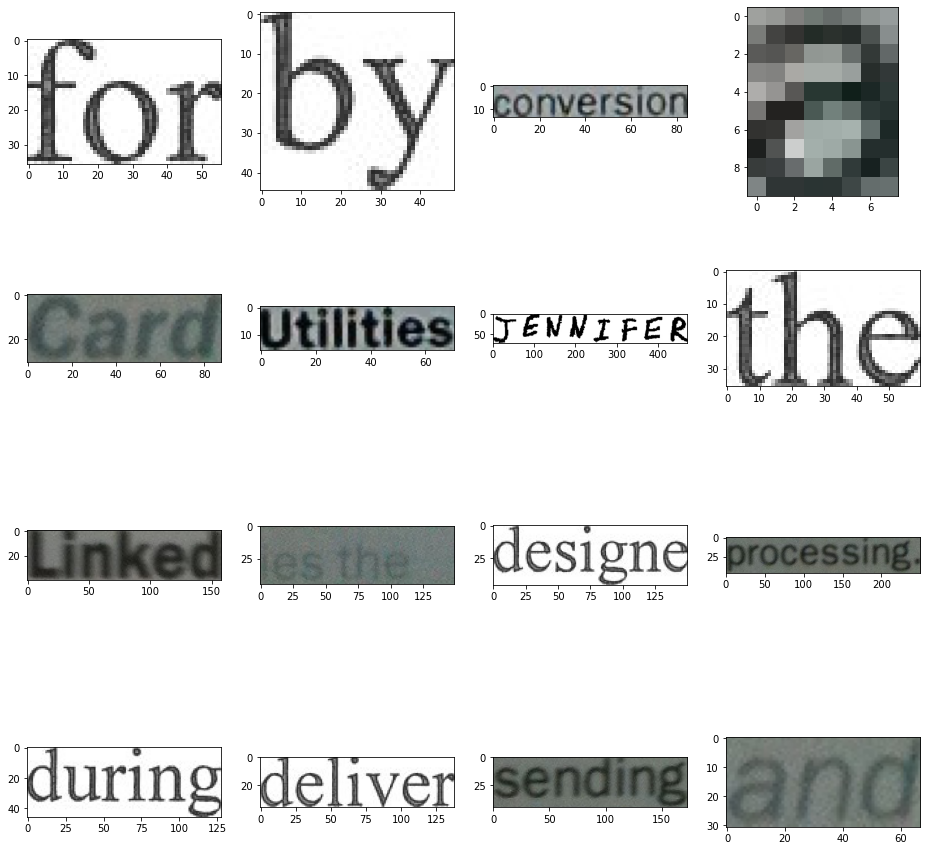

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
from os import listdir
from PIL import Image as PImage

def loadImages(path):
    
    imagesList = listdir(path)
    loadedImages = []
    for image in imagesList:
        img = PImage.open(path + image)
        loadedImages.append(img)

    return loadedImages

work_dir = './test_images/tesseract_samples/'
imgs = loadImages(work_dir)
plt.figure(figsize=(16, 16))
for idx,img in enumerate(imgs):
    plt.subplot(4,4,idx+1)   
    plt.imshow(img)

## 결과 분석과 결론 제시

- 우선 여러분들이 구현하고자 하는 서비스의 목적과 내용을 먼저 정리합니다.
- 여러분들이 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가기준을 제시합니다.
- 그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정합니다.

### Google OCR
전체 텍스트 블록과 블록 내 각각의 단어를 파악할 수 있음.
단순히 텍스트 내에 어떤 단어가 들어있는지 파악하거나, 단어 블록을 통째로 파악할 필요가 있을 때 사용하면 좋을듯.

### keras-OCR
각각의 단어 위치를 파악할 수 있음.

### Tesseract
이미지 내에서 단어별로 쪼개서 파악할 필요가 있을 때 좋을듯.


### 문제 가정
모의고사 시험지들을 스캔하는 작업을 한다고 가정.

이 상황에서, google OCR을 사용하면 각 텍스트 블록(지문 하나)을 파악하고, 해당 지문의 내용을 분석할 수 있음.

## 결과 보고서

OCR 이란 말이 시험 답안지 마킹하는데만 사용하는 것인 줄 알았는데, 활용할 수 있는 다양한 부분들이 있음을 알게되었음. 특히, 노드 내에 있던 추천 영상 : [https://tv.naver.com/v/4578167](https://tv.naver.com/v/4578167) 에서 길거리에 일본어와 영어가 혼재한 상황에서 각각의 단어를 인식하는 데모 영상이 인상깊었다.

사물 인식 말고도 문자 인식도 흥미가 가는 분야가 되었음.